# Noise reduction model training

In [1]:
!git clone https://github.com/karlosos/noise_reduction

Cloning into 'noise_reduction'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 109 (delta 40), reused 88 (delta 24), pack-reused 0
Receiving objects: 100% (109/109), 3.58 MiB | 9.34 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend 
import tensorflow as tf

In [26]:
from noise_reduction.model_unet import unet2 as unet

## Download training/testing data from [google drive link](https://drive.google.com/file/d/1-3XTuOUfU_xkgXZJgMrc4QZ_-ElvNrjs/view).

In [4]:
!gdown --id 1zj1xqzk4XUEIKA4_m7x99t8aTJQS4Pxx

Downloading...
From: https://drive.google.com/uc?id=1zj1xqzk4XUEIKA4_m7x99t8aTJQS4Pxx
To: /content/development_data.zip
12.8GB [04:54, 43.6MB/s]


In [5]:
!unzip -q development_data.zip

In [6]:
!rm development_data.zip

## Loading training data

In [7]:
from scipy import stats

train_path_spectograms = "./data/train/spectogram/"

X_in = np.load(train_path_spectograms + 'noisy_voice_amp_db.npy')
X_ou = np.load(train_path_spectograms + 'voice_amp_db.npy')
X_ou = X_in - X_ou

In [8]:
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

DescribeResult(nobs=81920000, minmax=(array([-80.]), array([0.])), mean=array([-48.060687]), variance=array([269.81029724]), skewness=array([0.06432652]), kurtosis=array([-0.35817752]))
DescribeResult(nobs=81920000, minmax=(array([-63.70250632]), array([80.])), mean=array([3.93130645]), variance=array([89.25955572]), skewness=array([2.15896037]), kurtosis=array([5.73673489]))


## Scaling data between -1 and 1

In [9]:
# Scale data between -1 and 1
X_in = (X_in + 46)/50
X_ou = (X_ou -6 )/82

print(X_in.shape)

print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

(5000, 128, 128)
DescribeResult(nobs=81920000, minmax=(array([-0.68]), array([0.92])), mean=array([-0.04121374]), variance=array([0.10792412]), skewness=array([0.06432652]), kurtosis=array([-0.35817752]))
DescribeResult(nobs=81920000, minmax=(array([-0.85003056]), array([0.90243902])), mean=array([-0.02522797]), variance=array([0.01327477]), skewness=array([2.15896037]), kurtosis=array([5.73673489]))


In [10]:
print(X_in.shape,X_ou.shape)

(5000, 128, 128) (5000, 128, 128)


## Reshape data for training and create test set for development

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Reshape for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

## Create generator

In [27]:
pretrained_weights = False

if pretrained_weights:
  # If training from pre-trained weights
  generator_nn=unet(pretrained_weights = root_path+'mod_unet_last_weights.h5')
else:
  #If training from scratch
  generator_nn=unet()

#Save best models to disk
checkpoint = ModelCheckpoint('./model/model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

generator_nn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_25[0][0]                  
____________________________________________________________________________________________

## Training

In [28]:
history = generator_nn.fit(X_train, y_train, epochs=50, batch_size=40, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
113/113 [==============================] - 18s 138ms/step - loss: 0.0070 - mae: 0.0924 - val_loss: 0.0071 - val_mae: 0.0928

Epoch 00001: val_loss improved from inf to 0.00712, saving model to ./model/model-001-0.006983-0.007119.h5
Epoch 2/50
113/113 [==============================] - 15s 131ms/step - loss: 0.0069 - mae: 0.0919 - val_loss: 0.0071 - val_mae: 0.0928

Epoch 00002: val_loss improved from 0.00712 to 0.00712, saving model to ./model/model-002-0.006937-0.007119.h5
Epoch 3/50
113/113 [==============================] - 15s 130ms/step - loss: 0.0069 - mae: 0.0919 - val_loss: 0.0071 - val_mae: 0.0928

Epoch 00003: val_loss improved from 0.00712 to 0.00712, saving model to ./model/model-003-0.006937-0.007119.h5
Epoch 4/50
113/113 [==============================] - 14s 128ms/step - loss: 0.0069 - mae: 0.0919 - val_loss: 0.0071 - val_mae: 0.0928

Epoch 00004: val_loss improved from 0.00712 to 0.00712, saving model to ./model/model-004-0.006937-0.007118.h5
Epoch 5/50
113/1

## Plot training progress

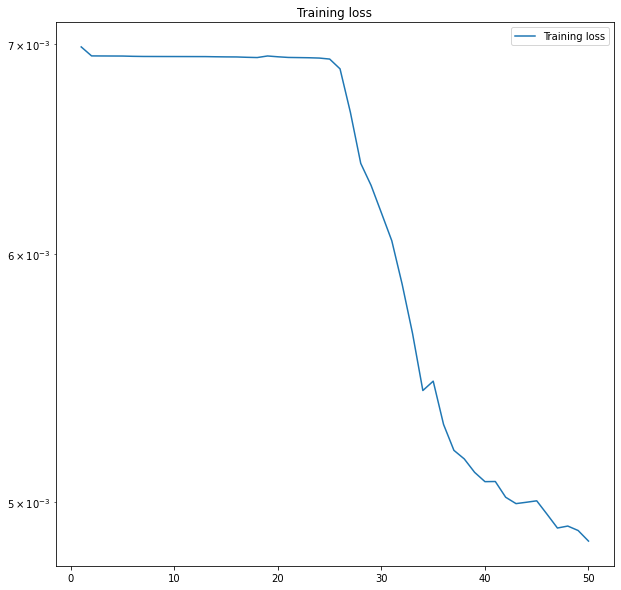

In [29]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, label='Training loss')
plt.yscale('log')
plt.title('Training loss')
plt.legend()
plt.show()

## Testing model

In [30]:
# Predict and QC the output
X_pred_test = generator_nn.predict(X_test)

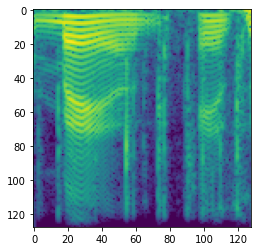

In [38]:
import matplotlib.pyplot as plt

id = 40
plt.imshow(X_test[id,:,:,0])

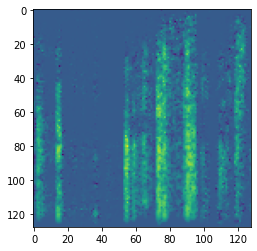

In [39]:
plt.imshow(y_test[id,:,:,0])

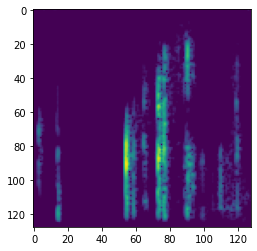

In [40]:
plt.imshow(X_pred_test[id,:,:,0])

In [53]:
# import os
# os.makedirs("plots/")
for id in range(X_test.shape[0]):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(X_test[id,:,:,0])
  axes[0].set_title("Input spectrogram (voice with noise)")
  axes[1].imshow(y_test[id,:,:,0])
  axes[1].set_title("Actual noise spectrogram")
  axes[2].imshow(X_pred_test[id,:,:,0])
  axes[2].set_title("Predicted noise spectrogram")
  plt.savefig(f"plots/plots_{id}.pdf")
  plt.close()

In [56]:
 !zip -qr plots.zip plots/
 !ls -l --block-size=M

total 85M
drwxr-xr-x 4 root root  1M Jun  7 19:51 data
drwx------ 5 root root  1M Jun  8 11:49 gdrive
drwxr-xr-x 2 root root  1M Jun  8 12:07 model
drwxr-xr-x 6 root root  1M Jun  8 10:53 noise_reduction
drwxr-xr-x 2 root root  1M Jun  8 12:24 plots
-rw-r--r-- 1 root root 85M Jun  8 12:26 plots.zip
drwxr-xr-x 1 root root  1M Jun  1 13:40 sample_data


In [57]:
!cp plots.zip /content/gdrive/MyDrive/noise_reduction/plots.zip

## Save weights to google drive

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/app/'

Mounted at /content/gdrive


In [34]:
#Save last model to disk
model_json = generator_nn.to_json()
with open("/content/gdrive/My Drive/noise_reduction/mod_unet_last_weights_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
generator_nn.save_weights("/content/gdrive/My Drive/noise_reduction/mod_unet_last_weights_2.h5")
print("Saved model to disk")

Saved model to disk
